## Введение

«Мегалайн» — федеральный оператор сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

#### Описание тарифов
Тариф «Смарт»\
Ежемесячная плата: 550 рублей\
Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика\
Стоимость услуг сверх тарифного пакета:\
минута разговора: 3 рубля\
сообщение: 3 рубля\
1 Гб интернет-трафика: 200 рублей

Тариф «Ультра»\
Ежемесячная плата: 1950 рублей\
Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика\
Стоимость услуг сверх тарифного пакета:\
минута разговора: 1 рубль\
сообщение: 1 рубль\
1 Гб интернет-трафика: 150 рублей

### Задача
Чтобы скорректировать рекламный бюджет, требуется определить, какой тариф является более прибыльным.

### Особенности алгоритмов.
Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно.
Для веб-трафика отдельные сессии не считаются. Общая сумма за месяц округляется в бо́льшую сторону.
С учетом этого минуты округлены вверх для каждого звонка, а интернет-трафик округлен вверх до Гб - по итогам месяца. 

### Описание данных:
###### Таблица users (информация о пользователях):
user_id — уникальный идентификатор пользователя\
first_name — имя пользователя\
last_name — фамилия пользователя\
age — возраст пользователя (годы)\
reg_date — дата подключения тарифа (день, месяц, год)\
churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)\
city — город проживания пользователя\
tarif — название тарифного плана\

###### Таблица calls (информация о звонках):
id — уникальный номер звонка
call_date — дата звонка
duration — длительность звонка в минутах
user_id — идентификатор пользователя, сделавшего звонок

###### Таблица messages (информация о сообщениях):\
id — уникальный номер сообщения\
message_date — дата сообщения\
user_id — идентификатор пользователя, отправившего сообщение\

######  Таблица internet (информация об интернет-сессиях):\
id — уникальный номер сессии\
mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)\
session_date — дата интернет-сессии\
user_id — идентификатор пользователя\

###### Таблица tariffs (информация о тарифах):\
tariff_name — название тарифа\
rub_monthly_fee — ежемесячная абонентская плата в рублях\
minutes_included — количество минут разговора в месяц, включённых в абонентскую плату\
messages_included — количество сообщений в месяц, включённых в абонентскую плату\
mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)\
rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)\
rub_per_message — стоимость отправки сообщения сверх тарифного пакета\
rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)\

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy import stats as st

df_calls = pd.read_csv('/datasets/calls.csv')
df_internet = pd.read_csv('/datasets/internet.csv')
df_messages = pd.read_csv('/datasets/messages.csv')
df_tariffs = pd.read_csv('/datasets/tariffs.csv')
df_users = pd.read_csv('/datasets/users.csv')

##  Исследование данных

### Анализ и обработка таблицы calls

In [3]:
df_calls.info()
df_calls.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


Заменим тип данных в call_date на дату

In [4]:
df_calls['call_date'] = pd.to_datetime(df_calls['call_date'], format='%Y-%m-%d')
df_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null datetime64[ns]
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB


Посмотрим распределение данных

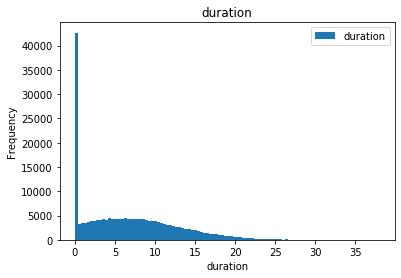

'Среднее: 6.755887210214849'

'Медиана:6.0'

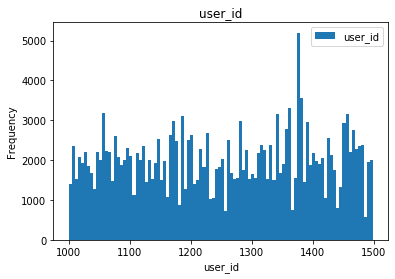

'Среднее: 1253.9406190309319'

'Медиана:1260.0'

In [5]:
def hyst (df,column):
    df.plot(kind='hist', y=column, bins = 100, title=column)
    plt.xlabel(column)
    plt.show( )

columns = ['duration', 'user_id']
for column in columns:
    hyst(df_calls, column)
    display(f"Среднее: {df_calls[column].mean()}")
    display(f"Медиана:{df_calls[column].median()}")

Исключим звонки длительностью 0 секунд, так как это пропущенные звонки, что не искажать средние показатели.

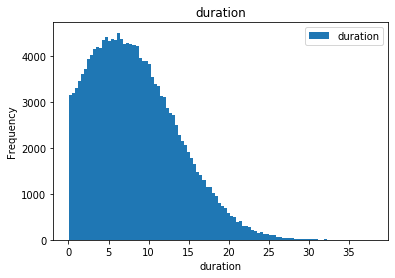

'Среднее: 8.39779402922807'

'Медиана:7.74'

'Максимум:38.0'

In [6]:
df_calls_edit = df_calls
df_calls_edit = df_calls_edit[df_calls_edit['duration']>0]
hyst(df_calls_edit, 'duration')
display(f"Среднее: {df_calls_edit['duration'].mean()}")
display(f"Медиана:{df_calls_edit['duration'].median()}")
display(f"Максимум:{df_calls_edit['duration'].max()}")

Динного хвоста нет. С данными можно работать.

### Анализ и обработка таблицы internet

In [7]:
df_internet.info()
df_internet.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


Заменим тип данных в session_date на дату

In [8]:
df_internet['session_date'] = pd.to_datetime(df_internet['session_date'], format='%Y-%m-%d')
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null datetime64[ns]
user_id         149396 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 5.7+ MB


Посмотрим распределение данных

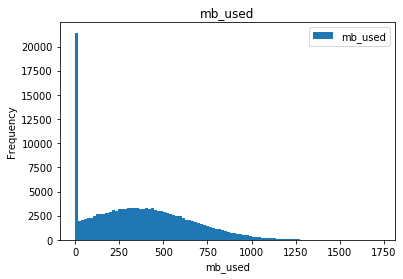

'Среднее: 370.1924263701839'

'Медиана:348.015'

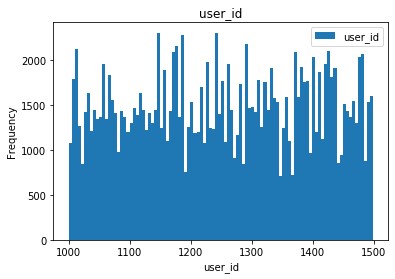

'Среднее: 1252.0998420305764'

'Медиана:1251.0'

'Минимум:0.0'

In [9]:
columns = ['mb_used', 'user_id']
for column in columns:
    hyst(df_internet, column)
    display(f"Среднее: {df_internet[column].mean()}")
    display(f"Медиана:{df_internet[column].median()}")
display(f"Минимум:{df_internet['mb_used'].min()}")

Так как для веб-трафика отдельные сессии не считаются, а считается общая сумма за месяц, то нет смысла исклбчать нулевые сессии.

### Анализ и обработка таблицы messages

In [10]:
df_messages.info()
df_messages.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


Заменим тип данных в message_date на дату

In [11]:
df_messages['message_date'] = pd.to_datetime(df_messages['message_date'], format='%Y-%m-%d')
df_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null datetime64[ns]
user_id         123036 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


Посмотрим распределение данных

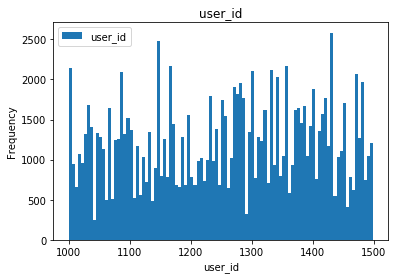

'Среднее: 1256.9894096036933'

'Медиана:1271.0'

In [12]:
hyst(df_messages, 'user_id')
display(f"Среднее: {df_messages['user_id'].mean()}")
display(f"Медиана:{df_messages['user_id'].median()}")


### Анализ и обработка таблицы tariffs

In [13]:
df_tariffs.info()
df_tariffs

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


для удобства в работе сделаем индексом названия тарифов

In [14]:
df_tariffs = df_tariffs.set_index('tariff_name')

### Анализ и обработка таблицы users

In [15]:
df_users.info()
df_users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [16]:
len(df_users['user_id'].unique())# уникальных абонентов 500, столько же записей. Значит нет абонентов, у которых было 2 тарифа в году.

500

Проверим столбец city на неявные дубликаты.

In [17]:
df_users['city'].unique()

array(['Краснодар', 'Москва', 'Стерлитамак', 'Новокузнецк',
       'Набережные Челны', 'Ульяновск', 'Челябинск', 'Пермь', 'Тюмень',
       'Самара', 'Санкт-Петербург', 'Иваново', 'Чебоксары', 'Омск', 'Уфа',
       'Томск', 'Чита', 'Мурманск', 'Петрозаводск', 'Тверь',
       'Екатеринбург', 'Махачкала', 'Вологда', 'Череповец', 'Ярославль',
       'Сочи', 'Хабаровск', 'Ставрополь', 'Рязань', 'Улан-Удэ', 'Тула',
       'Саратов', 'Ростов-на-Дону', 'Казань', 'Иркутск', 'Курск',
       'Калуга', 'Якутск', 'Астрахань', 'Химки', 'Владикавказ',
       'Волгоград', 'Саранск', 'Ижевск', 'Новосибирск', 'Брянск',
       'Тольятти', 'Нижний Тагил', 'Орёл', 'Белгород', 'Воронеж',
       'Волжский', 'Курган', 'Барнаул', 'Красноярск', 'Архангельск',
       'Липецк', 'Кемерово', 'Киров', 'Сургут', 'Пенза', 'Магнитогорск',
       'Нижний Новгород', 'Кострома', 'Владивосток', 'Тамбов', 'Балашиха',
       'Севастополь', 'Калининград', 'Оренбург', 'Смоленск',
       'Нижневартовск', 'Владимир', 'Новороссий

Славно, что все в порядке))

## Подготовка данных

### Расчет количества сделанных звонков и израсходованных минут разговора по месяцам по пользователям

In [23]:
df_calls_edit['month'] = pd.DatetimeIndex(df_calls_edit['call_date']).month #добавим месяц, для группирковки

def roundup (row): 
    """
    округляет значение в строке вверх
    """
    return math.ceil(row['duration'])
df_calls_edit['minutes'] = df_calls_edit.apply(roundup, axis=1)
calls_per_user = pd.pivot_table(df_calls_edit, index=('user_id','month'), values = 'minutes', aggfunc=('count', 'sum')).reset_index()
calls_per_user.rename(columns={'count': 'calls_number', 'sum': 'minutes'}, inplace=True)
display(calls_per_user)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,user_id,month,calls_number,minutes
0,1000,5,17,159
1,1000,6,28,172
2,1000,7,41,340
3,1000,8,42,408
4,1000,9,46,466
...,...,...,...,...
3163,1498,10,30,247
3164,1499,9,8,70
3165,1499,10,44,449
3166,1499,11,62,612


### Расчет количества отправленных сообщений по месяцам по пользователям

In [19]:
df_messages['month'] = pd.DatetimeIndex(df_messages['message_date']).month #добавим месяц, для группирковки
messages_per_user = pd.pivot_table(df_messages, index=['user_id', 'month'], values = 'id', aggfunc='count').reset_index()
messages_per_user.rename(columns={'id': 'messages'}, inplace=True)
display(messages_per_user)

,user_id,month,messages
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57
...,...,...,...
2712,1498,10,42
2713,1499,9,11
2714,1499,10,48
2715,1499,11,59


### Расчет объема израсходованного интернет-трафика по месяцам по пользователям

In [24]:
df_internet['month'] = pd.DatetimeIndex(df_internet['session_date']).month #добавим месяц, для группирковки
internet_per_user = pd.pivot_table(df_internet, index=['user_id', 'month'], values = 'mb_used', aggfunc='sum').reset_index()
display(internet_per_user)

,user_id,month,mb_used
0,1000,5,2253.49
1,1000,6,23233.77
2,1000,7,14003.64
3,1000,8,14055.93
4,1000,9,14568.91
...,...,...,...
3198,1498,10,20579.36
3199,1499,9,1845.75
3200,1499,10,17788.51
3201,1499,11,17963.31


Объединим таблицы с помесячными данными в одну.

In [35]:
common = calls_per_user.merge(messages_per_user, on = ['month', 'user_id'], how='outer')
common = common.merge(internet_per_user, on = ['month', 'user_id'], how='outer')
common = common.merge(df_users, on = 'user_id', how='inner')
common['gb'] = np.ceil(common['mb_used']/1024)
display (common)

,month,user_id,calls_number,minutes,messages,mb_used,age,churn_date,city,first_name,last_name,reg_date,tariff,gb
0,1,1005,11.0,95.0,7.0,2727.97,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,smart,3.0
1,2,1005,55.0,456.0,38.0,7383.93,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,smart,8.0
2,3,1005,63.0,606.0,56.0,11104.25,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,smart,11.0
3,4,1005,77.0,712.0,41.0,9351.72,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,smart,10.0
4,5,1005,62.0,595.0,42.0,7865.53,67,NaN,Набережные Челны,Афанасий,Горлов,2018-01-25,smart,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,11,1489,NaN,NaN,20.0,17491.56,35,NaN,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,18.0
3210,12,1489,NaN,NaN,35.0,17322.51,35,NaN,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,17.0
3211,10,1328,NaN,NaN,6.0,22427.98,44,NaN,Мурманск,Рауль,Аркадьев,2018-10-16,ultra,22.0
3212,11,1328,NaN,NaN,8.0,35525.58,44,NaN,Мурманск,Рауль,Аркадьев,2018-10-16,ultra,35.0


При объединении получилась таблица, в которой у некоторых абонентов за месяц не было
Заменим пропуски на нули и установим для целочисленных значений тип integer.

In [36]:
common=common.fillna(0)
columns = ['calls_number', 'minutes', 'messages', 'gb']
for column in columns:
    common[column] = common[column].astype('int')
common.info()
display (common)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 14 columns):
month           3214 non-null int64
user_id         3214 non-null int64
calls_number    3214 non-null int64
minutes         3214 non-null int64
messages        3214 non-null int64
mb_used         3214 non-null float64
age             3214 non-null int64
churn_date      3214 non-null object
city            3214 non-null object
first_name      3214 non-null object
last_name       3214 non-null object
reg_date        3214 non-null object
tariff          3214 non-null object
gb              3214 non-null int64
dtypes: float64(1), int64(7), object(6)
memory usage: 376.6+ KB


,month,user_id,calls_number,minutes,messages,mb_used,age,churn_date,city,first_name,last_name,reg_date,tariff,gb
0,1,1005,11,95,7,2727.97,67,0,Набережные Челны,Афанасий,Горлов,2018-01-25,smart,3
1,2,1005,55,456,38,7383.93,67,0,Набережные Челны,Афанасий,Горлов,2018-01-25,smart,8
2,3,1005,63,606,56,11104.25,67,0,Набережные Челны,Афанасий,Горлов,2018-01-25,smart,11
3,4,1005,77,712,41,9351.72,67,0,Набережные Челны,Афанасий,Горлов,2018-01-25,smart,10
4,5,1005,62,595,42,7865.53,67,0,Набережные Челны,Афанасий,Горлов,2018-01-25,smart,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,11,1489,0,0,20,17491.56,35,0,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,18
3210,12,1489,0,0,35,17322.51,35,0,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,17
3211,10,1328,0,0,6,22427.98,44,0,Мурманск,Рауль,Аркадьев,2018-10-16,ultra,22
3212,11,1328,0,0,8,35525.58,44,0,Мурманск,Рауль,Аркадьев,2018-10-16,ultra,35


### Расчет помесячной выручки с каждого пользователя

In [37]:
def revenue (row):
    tariff = row['tariff'] #определяем тариф для строки

    monthly_fee = df_tariffs.loc[tariff,'rub_monthly_fee']
    per_minute = df_tariffs.loc[tariff,'rub_per_minute'] 
    per_message = df_tariffs.loc[tariff,'rub_per_message']
    per_gb = df_tariffs.loc[tariff,'rub_per_gb']

    minutes_included = df_tariffs.loc[tariff,'minutes_included']
    messages_included = df_tariffs.loc[tariff,'messages_included'] 
    gb_included = df_tariffs.loc[tariff,'mb_per_month_included']/1024
    
    # стоимость за звонки, сообщения, Гб сверх пакета:
    minutes_сharge = 0
    messages_сharge = 0
    gb_сharge = 0
    if (row['minutes']-minutes_included)>0: 
        minutes_сharge = (row['minutes']-minutes_included)*per_minute
    if (row['messages']-messages_included)>0: 
        messages_сharge = (row['messages']-messages_included)*per_message
    if (row['gb']-gb_included)>0: 
        gb_сharge = (row['gb']-gb_included)*per_gb

    revenue = monthly_fee + minutes_сharge + messages_сharge + gb_сharge
    return revenue
        
common['revenue'] = common.apply(revenue, axis=1)
display(common)

,month,user_id,calls_number,minutes,messages,mb_used,age,churn_date,city,first_name,last_name,reg_date,tariff,gb,revenue
0,1,1005,11,95,7,2727.97,67,0,Набережные Челны,Афанасий,Горлов,2018-01-25,smart,3,550.0
1,2,1005,55,456,38,7383.93,67,0,Набережные Челны,Афанасий,Горлов,2018-01-25,smart,8,550.0
2,3,1005,63,606,56,11104.25,67,0,Набережные Челны,Афанасий,Горлов,2018-01-25,smart,11,886.0
3,4,1005,77,712,41,9351.72,67,0,Набережные Челны,Афанасий,Горлов,2018-01-25,smart,10,1186.0
4,5,1005,62,595,42,7865.53,67,0,Набережные Челны,Афанасий,Горлов,2018-01-25,smart,8,835.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,11,1489,0,0,20,17491.56,35,0,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,18,1150.0
3210,12,1489,0,0,35,17322.51,35,0,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,17,950.0
3211,10,1328,0,0,6,22427.98,44,0,Мурманск,Рауль,Аркадьев,2018-10-16,ultra,22,1950.0
3212,11,1328,0,0,8,35525.58,44,0,Мурманск,Рауль,Аркадьев,2018-10-16,ultra,35,2700.0


## Анализ данных

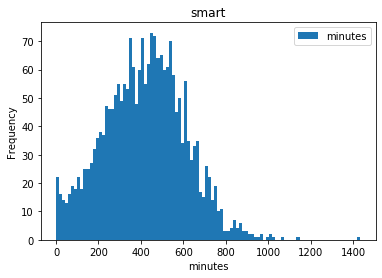

'Среднее: 418'

'Медиана:422'

'Дисперсия:36203'

'СКО:190'

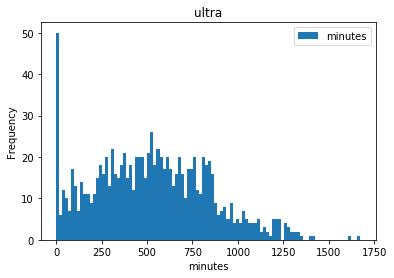

'Среднее: 527'

'Медиана:518'

'Дисперсия:100771'

'СКО:317'

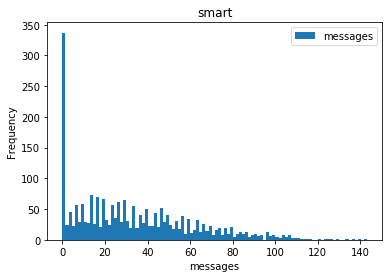

'Среднее: 33'

'Медиана:28'

'Дисперсия:796'

'СКО:28'

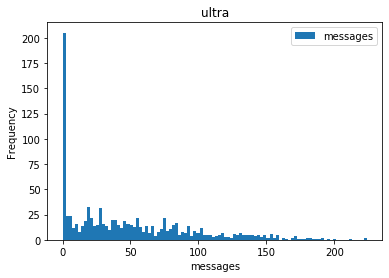

'Среднее: 49'

'Медиана:38'

'Дисперсия:2283'

'СКО:48'

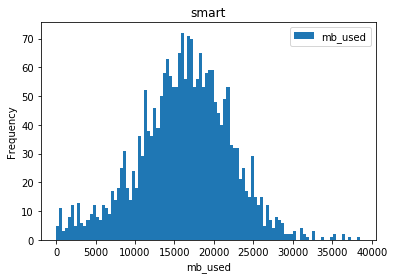

'Среднее: 16208'

'Медиана:16507'

'Дисперсия:34447035'

'СКО:5869'

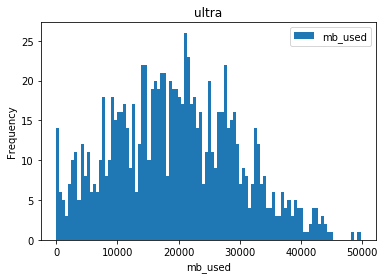

'Среднее: 19469'

'Медиана:19308'

'Дисперсия:101647713'

'СКО:10082'

In [38]:
metrics = ('minutes', 'messages', 'mb_used')
tariffs = ('smart', 'ultra')
for metric in metrics:
    for tariff in tariffs:
        common[common['tariff']==tariff].plot(kind='hist', y=metric, bins = 100, title=tariff)
        plt.xlabel(metric)
        plt.show( )
        display(f"Среднее: {common[common['tariff']==tariff][metric].mean():.0f}")
        display(f"Медиана:{common[common['tariff']==tariff][metric].median():.0f}")
        display(f"Дисперсия:{np.var(common[common['tariff']==tariff][metric]):.0f}")
        display(f"СКО:{np.sqrt(np.var(common[common['tariff']==tariff][metric])):.0f}")

  В среднем:| Smart  | Ultra |
-------------| ------------- | ------------- |
минут| 418  | 527  |
сообщений| 33  | 49  |
Мб| 16 208  | 19 469  |
 
Очевидно, что пользователи тарифа Ultra активнее используют связь: на тарифе Ultra средние значения выше. При этом разброс от среднего для этих пользователей больше, чем для тарифа Smart. 

На тарифе Ultra значительное число пользователей совсем не используют минуты. Многие пользователи обоих тарифов совсем не отправляют смс. Больше половины пользователей Smart используют Мб сверх пакета. В то время как примерно 70% пользователей Ultra хватает 30 Гб.

## Проверка гипотез

### Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются
Пусть Гипотеза Н0:средняя выручка пользователей тарифов «Ультра» и «Смарт» не различается. Н1 - средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.  Это двухсторонние гипотезы о равенстве средних двух генеральных совокупностей. Построим распределение выручки для обоих тарифов. 

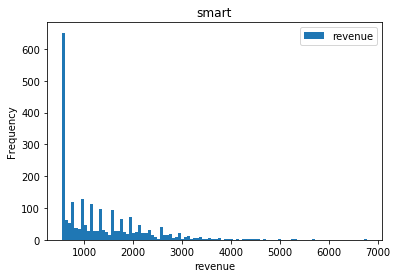

'Среднее: 1290'

'Медиана:1023'

'Дисперсия:669485'

'СКО:818'

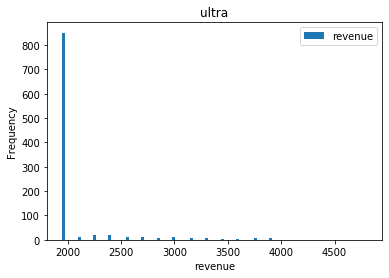

'Среднее: 2070'

'Медиана:1950'

'Дисперсия:141373'

'СКО:376'

In [39]:
tariffs = ('smart', 'ultra')
for tariff in tariffs:
    common[common['tariff']==tariff].plot(kind='hist', y='revenue', bins = 100, title=tariff)
    plt.xlabel('revenue')
    plt.show( )
    display(f"Среднее: {common[common['tariff']==tariff]['revenue'].mean():.0f}")
    display(f"Медиана:{common[common['tariff']==tariff]['revenue'].median():.0f}")
    display(f"Дисперсия:{np.var(common[common['tariff']==tariff]['revenue']):.0f}")
    display(f"СКО:{np.sqrt(np.var(common[common['tariff']==tariff]['revenue'])):.0f}")

Итак, нужно посчитать с какой вероятностью при выборочных средних значений выручки пользователей тарифа Smart - 1290 руб и тарифа Ultra - 2070 руб средние этих генеральных совокупностей равны. Используем t-тест, так как 1) пользователи двух тарифов представляют собой независимые совокупности; 2)выборочные средние нормально распределены, так как числов наблюдений в выборках достаточно большое.

In [40]:
revenue_smart = common[common['tariff']=='smart']['revenue']
revenue_ultra = common[common['tariff']=='ultra']['revenue']
alpha =0.01
results = st.ttest_ind(revenue_smart,revenue_ultra, equal_var = False)# так как дисперсии выборок разные, то ставим параметру equal_var значение False
display('p-значение:', results.pvalue)

'p-значение:'

4.2606313931076085e-250

Таким образом, веротность того, что средние одинаковые и будут равны 1290 и 2070 равна 4.2*10 в степени -160, т.е. 0. Следовательно Н0 отвергаем, верна Н1, что средние не равны.

### Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов
Пусть Гипотеза Н0:средняя выручка пользователей из Москвы и других регионов не различается. Н1 - средняя выручка пользователей из Москвы и других регионов различается.  Это двух
торонние гипотезы о равенстве средних двух генеральных совокупностей. Построим распределение выручки для обоих выборок. 

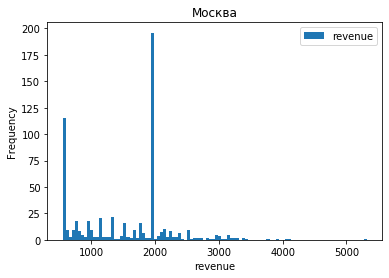

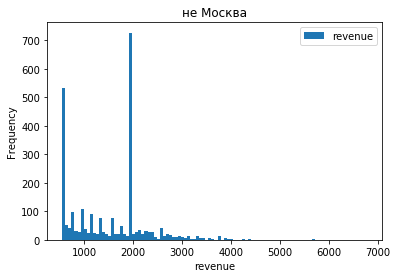

'Среднее Москва: 1547'

'СКО Москва:751'

'Среднее не Москва: 1525'

'СКО не Москва:809'

In [41]:
common[common['city']=='Москва'].plot(kind='hist', y='revenue', bins = 100, title='Москва')
plt.xlabel('revenue')
plt.show( )

common[common['city']!='Москва'].plot(kind='hist', y='revenue', bins = 100, title='не Москва')
plt.xlabel('revenue')
plt.show( )

display(f"Среднее Москва: {common[common['city']=='Москва']['revenue'].mean():.0f}")
display(f"СКО Москва:{np.sqrt(np.var(common[common['city']=='Москва']['revenue'])):.0f}")

display(f"Среднее не Москва: {common[common['city']!='Москва']['revenue'].mean():.0f}")
display(f"СКО не Москва:{np.sqrt(np.var(common[common['city']!='Москва']['revenue'])):.0f}")

Итак, нужно проверить с какой вероятностью выборочное среднее для генеральной совокупности абонентов из Москвы и для генеральной совокупности абонентов из регионов могут быть 1547 руб. и 1525 руб. соответственно при условии что средние этих генеральных совокупностей равны. Используем t-тест, так как 1) пользователи двух тарифов представляют собой независимые совокупности; 2)выборочные средние нормально распределены, так как числов наблюдений в выборках достаточно большое.

In [42]:
revenue_moscow = common[common['city']=='Москва']['revenue']
revenue_regions = common[common['city']!='Москва']['revenue']
alpha =0.01
results = st.ttest_ind(revenue_moscow,revenue_regions, equal_var = False)# так как дисперсии выборок разные, то ставим параметру equal_var значение False
display('p-значение:', results.pvalue)

'p-значение:'

0.5257376663729298

Вероятность 0,53 - довольно большая. Поэтому гипотеза Н0:средняя выручка пользователей из Москвы и других регионов не различается, не может быть отвергнута.

## Общий вывод

1) Мы описали поведение среднего пользователя каждого тарифа. Пользователи тарифа Smart примерно в половине случаев превышают лимиты звонков, сообщений и интернета. Пользователи тарифа Ultra совсем не превышают лимиты минут и сообщений и в 70% случаев лимиты интернета.

2) средняя выручка тарифа Ultra - 2070 руб/мес, что больше, чем у тарифа Smart - 1290. Поэтому выгоднее продвигать тариф Ultra.

3) Выручка абонентов Москвы и остальных регионов отличается примерно в половине случаев. На основе данной выборки нельзя сделать определенный вывод, отличается ли выручка для этих совокупностей, а значит нельзя сказать, где выгоднее продвигать услуги (в Москве или регионах).

